In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch import Tensor
import numpy as np

from ray import train as ray_train
from ray import tune
from ray.tune.search.optuna import OptunaSearch

from pathlib import Path

import params.learning
from params.learning import LEARNING
from dataset import get_dataloader
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

from custom_transforms import (
    Cutout,
    Shadowcasting,
)

from params import PROJECT_PATH

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters list

In [19]:
# Define ablation range of data augmentation

image_augmentation_transforms = [
    transforms.ColorJitter(
        brightness=0.9, contrast=0.3, saturation=1, hue=0.1
    ),
    transforms.GaussianBlur(3),
    transforms.GaussianBlur(7),
    transforms.RandomSolarize(0.5),
    Cutout(),
    Shadowcasting(),
]
augmentation_transforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(
        params.learning.IMAGE_SHAPE,
        scale=(0.2, 1.0),
        ratio=(3, 3),
        antialias=True,
    ),
    transforms.Normalize(
        Tensor([0.4333, 0.4610, 0.4413, 0.0926, 0.4989, 0.5924, 0.8239]),
        Tensor([0.2223, 0.2146, 0.2154, 0.0817, 0.2162, 0.2504, 0.1614]),
    ),
]

In [20]:
# Optimizer hyperparameters
optimizers = [
    optim.Adam,
    # optim.SGD,  # Clearly less performant than Adam on previous runs
    optim.RMSprop,
    optim.AdamW,
    optim.Adamax,
    optim.ASGD,
]
learning_rates = [1e-5, 1e-3]

In [21]:
image_augmentation_search_space = {
    f"image_augmentation_{i}": tune.choice([True, False])
    for i, aug in enumerate(image_augmentation_transforms)
}

augmentation_search_space = {
    f"augmentation_{i}": tune.choice([True, False])
    for i, aug in enumerate(augmentation_transforms)
}

In [22]:
search_space = {
    "nb_epochs": 200,
    "learning_rate": tune.loguniform(*learning_rates),
    "optimizer": tune.choice(optimizers),
    **image_augmentation_search_space,
    **augmentation_search_space,
}

# Black-box optimizer

In [23]:
def get_multiple_choice(
    config: dict, prefix: str, choices: []
) -> transforms.Compose:
    return transforms.Compose(
        [
            aug
            for i, aug in enumerate(choices)
            if f"{prefix}_{i}" in config and config[f"{prefix}_{i}"]
        ]
    )

In [24]:
criterion_regression = nn.MSELoss()


def trial(config, *, early_stop=True):
    image_augmentation_transform = get_multiple_choice(
        config, "image_augmentation", image_augmentation_transforms
    )
    augmentation_transform = get_multiple_choice(
        config, "augmentation", augmentation_transforms
    )

    model = ResNet18Velocity_Regression_Alt().to(device)
    train_loader, val_loader, _ = get_dataloader(
        params.learning.DATASET,
        image_augmentation_transform=image_augmentation_transform,
        augmentation_transform=augmentation_transform,
        multimodal_transform=transforms.Resize(
            params.learning.IMAGE_SHAPE, antialias=True
        ),
        batch_size=params.learning.LEARNING["batch_size"],
    )
    optimizer = config["optimizer"](
        model.parameters(),
        lr=config["learning_rate"],
    )

    scheduler = optim.lr_scheduler.LinearLR(
        optimizer=optimizer, total_iters=config["nb_epochs"]
    )

    min_val = np.inf
    nb_epoch_without_improvement = 0

    for epoch in range(config["nb_epochs"]):
        train_regression_loss = train(
            model,
            device,
            train_loader,
            optimizer,
            scheduler,
            criterion_regression,
            epoch,
        )

        val_regression_loss = validate(
            model, device, val_loader, criterion_regression, epoch
        )

        ray_train.report(
            {
                "train_loss": train_regression_loss,
                "val_loss": val_regression_loss,
            }
        )

        if val_regression_loss < min_val:
            min_val = val_regression_loss
            nb_epoch_without_improvement = 0
        else:
            nb_epoch_without_improvement += 1

        if early_stop and nb_epoch_without_improvement > 10:
            break

In [ ]:
algo = OptunaSearch()
gpu_trial = tune.with_resources(trial, {"cpu": 12, "gpu": 1})

tuner = tune.Tuner(
    gpu_trial,
    tune_config=tune.TuneConfig(
        metric="val_loss",
        mode="min",
        search_alg=algo,
        num_samples=100,
    ),
    param_space=search_space,
)
results = tuner.fit()

In [ ]:
results.experiment_path

In [30]:
from ray.tune.analysis import ExperimentAnalysis

results = tune.Tuner.restore(
    "/home/g_thomas/ray_results/trial_2023-10-18_15-53-36/",
    trainable=gpu_trial,
).get_results()

In [31]:
print("Best hyperparameters found were: ", results.get_best_result().config)

Best hyperparameters found were:  {'nb_epochs': 200, 'learning_rate': 0.00010384159955189438, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'image_augmentation_0': False, 'image_augmentation_1': False, 'image_augmentation_2': True, 'image_augmentation_3': True, 'image_augmentation_4': False, 'image_augmentation_5': False, 'augmentation_0': True, 'augmentation_1': True, 'augmentation_2': True, 'augmentation_3': False}


In [32]:
print(results.get_best_result())

Result(
  metrics={'train_loss': 0.699599524554999, 'val_loss': 0.6452513138453165},
  path='/home/g_thomas/ray_results/trial_2023-10-18_15-53-36/trial_ccc4813f_38_augmentation_0=True,augmentation_1=True,augmentation_2=True,augmentation_3=False,image_augmentation_0=False,imag_2023-10-19_10-57-33',
  filesystem='local',
  checkpoint=None
)


In [33]:
df = results.get_dataframe()
best = df.iloc[df["val_loss"].argmin()]
best

train_loss                                                0.6996
val_loss                                                0.645251
timestamp                                             1697710588
done                                                       False
training_iteration                                            76
trial_id                                                ccc4813f
date                                         2023-10-19_12-16-28
time_this_iter_s                                       31.507401
time_total_s                                          2589.01325
pid                                                       558020
hostname                                            buenos-aires
node_ip                                           147.250.35.113
time_since_restore                                    2589.01325
iterations_since_restore                                      76
checkpoint_dir_name                                         None
config/nb_epochs         

In [34]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = False

In [35]:
df["config/optimizer"] = df["config/optimizer"].astype(str)

In [36]:
min(df["val_loss"])

0.6452513138453165

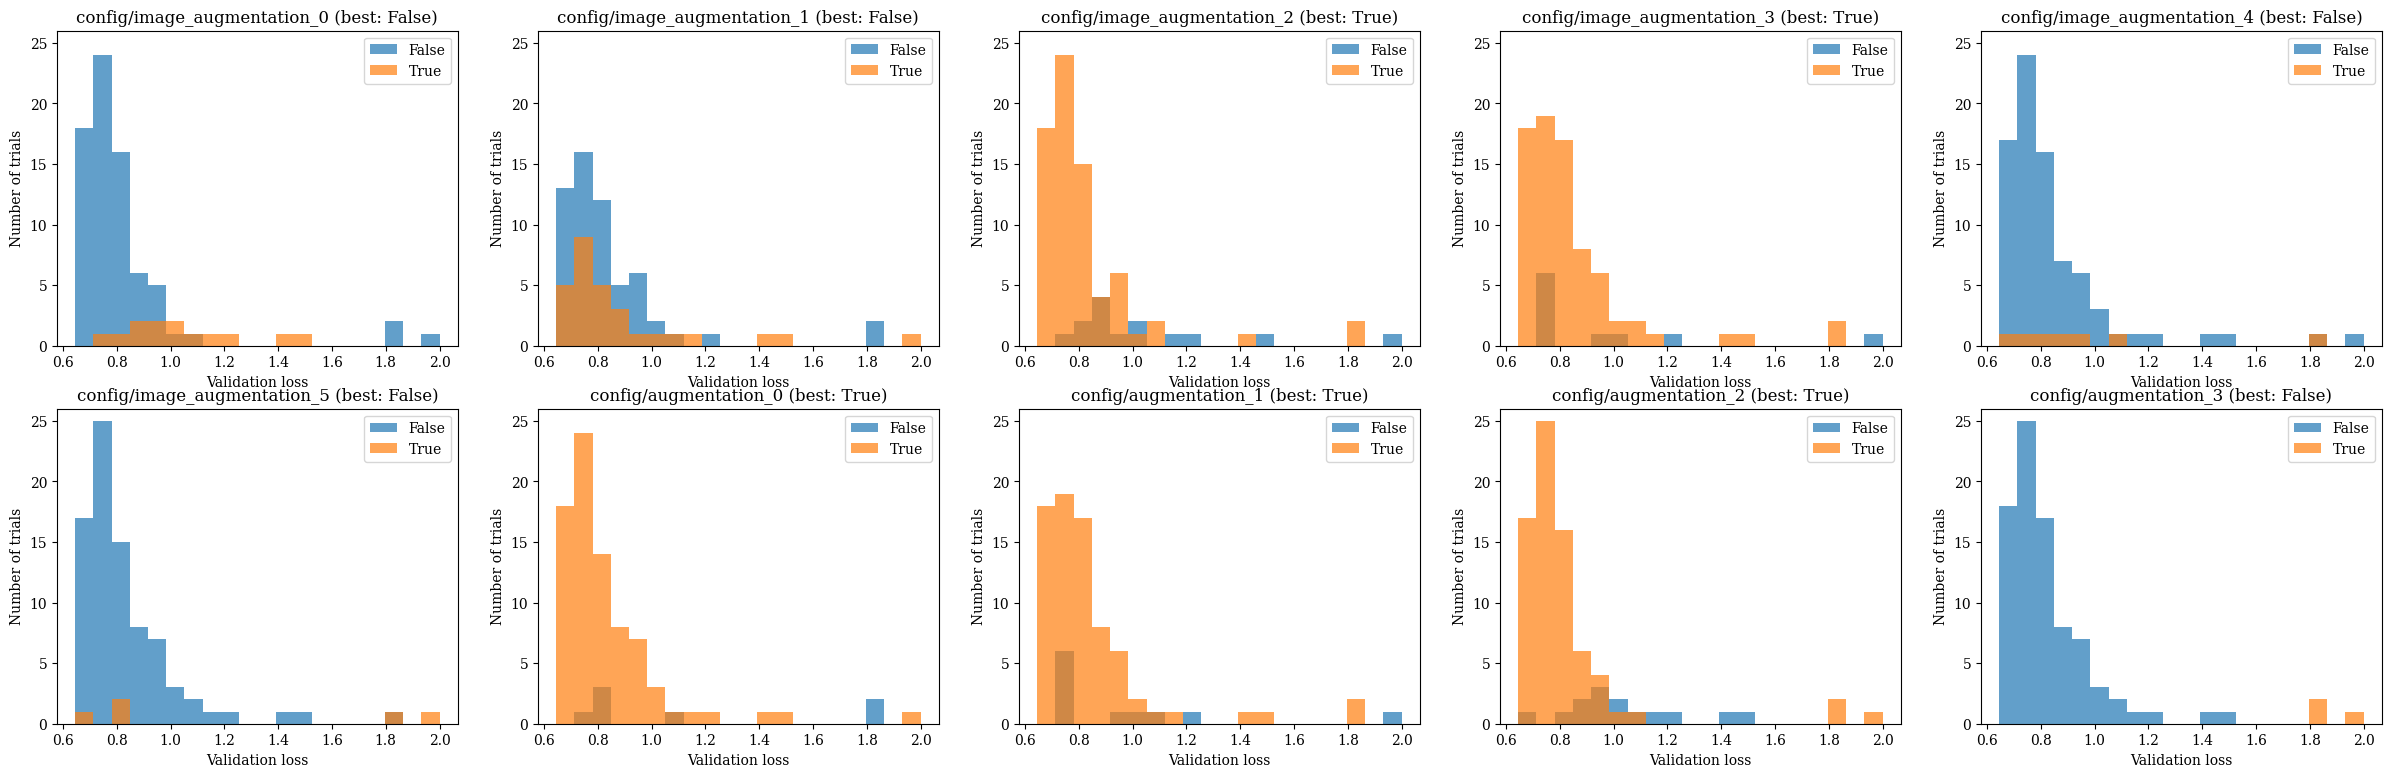

In [82]:
range_ = df["val_loss"].min(), 2
NB_ROWS = 2
columns = [col for col in df.columns if "augmentation" in col]

_, ax_list = plt.subplots(
    NB_ROWS, len(columns) // NB_ROWS, figsize=(3 * len(columns), 9)
)

for col, ax in zip(columns, ax_list.flatten()):
    ax.set_title(f"{col} (best: {best[col]})")
    # ax.set_xticks(rotation=90)

    if "augmentation" in col:
        for value, group in df.groupby(col):
            ax.hist(
                group["val_loss"],
                label=value,
                range=range_,
                bins=20,
                alpha=0.7,
            )

    ax.set_xlabel("Validation loss")
    ax.set_ylabel("Number of trials")
    ax.legend()
    ax.set_ylim(0, 26)

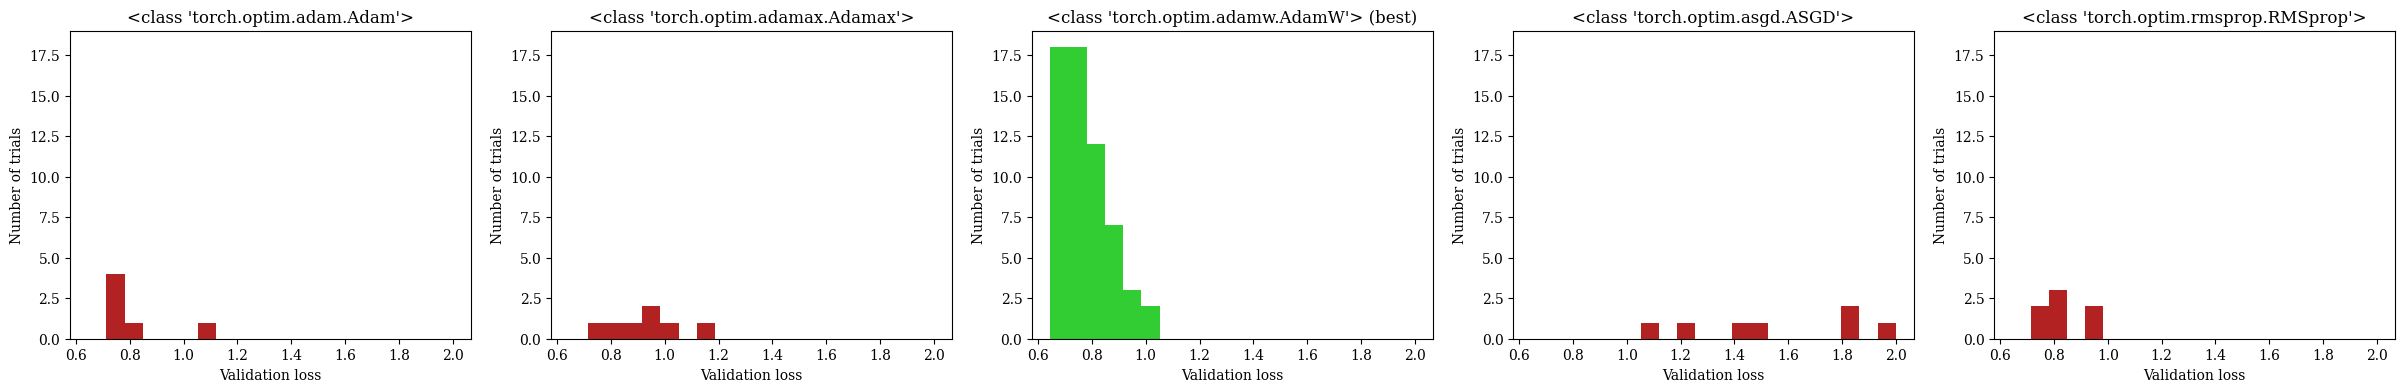

In [84]:
_, ax_list = plt.subplots(1, len(optimizers), figsize=(6 * len(optimizers), 4))

for ax, (opt, group) in zip(ax_list, df.groupby("config/optimizer")):
    title = f"{opt}"
    color = "firebrick"
    if str(best["config/optimizer"]) == opt:
        color = "limegreen"
        title += " (best)"

    ax.set_title(title)
    ax.hist(
        group["val_loss"],
        range=range_,
        bins=20,
        color=color,
    )
    ax.set_xlabel("Validation loss")
    ax.set_ylabel("Number of trials")
    ax.set_ylim(0, 19)